## SVD 
---
Surprise algorithm: SVD(biased=False, n_epochs = 100)

Hyperparameter: 
1. Threshold when do the recommendation
2. n_factors in SVD 

Things to do:
1. Calculate test loss
2. Do the recommendations (done)
3. Calculate precision, recall

In [1]:
import random
import pandas as pd
import json
import numpy as np
import scipy.sparse as sp
import time
from collections import defaultdict

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import rc
rc('figure', figsize=(16, 8), max_open_warning=False)

from surprise import SVD
from surprise import Dataset, Reader
from surprise import accuracy
from surprise.model_selection import train_test_split

import sys
sys.path.insert(0, '../src')

import preprocess
import evaluation
import utils

In [31]:
def create_surprise_paper_paper_data_from_tsv(datafilename,datadir="../dblp-ref/4fold"):
    itemList, userList, ratingList = [], [], []

    df = pd.read_table(datadir+"/"+datafilename,
                       usecols=[0, 1, 2],
                       names=['userID', 'itemID', 'rating'],
                       na_filter=False)
    reader = Reader(rating_scale=(0,1))

    data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)

    return data

In [35]:
trainset = create_surprise_paper_paper_data_from_tsv("4fold_0_train.tsv").build_full_trainset()
temp = create_surprise_paper_paper_data_from_tsv("4fold_0_val.tsv").build_full_trainset()
testset = temp.build_testset()

print('usernum = ', usernum, 'itemnum = ', itemnum)
print('# relationship in trainset = ', trainset.n_ratings)
print('# relationship in testset = ', temp.n_ratings)

usernum =  2556 itemnum =  2300
# relationship in trainset =  500942
# relationship in testset =  50732


In [2]:
random_dict = preprocess.create_random_subset_paper_paper_data(debug=True)
# random_dict = preprocess.create_paper_paper_dict(debug=False)
traindict, testdict = preprocess.create_train_test_dic(random_dict)

trainset = preprocess.create_surprise_paper_paper_data(traindict).build_full_trainset()
temp     = preprocess.create_surprise_paper_paper_data(testdict).build_full_trainset()
testset  = temp.build_testset()

usernum = trainset.n_users
itemnum = trainset.n_items

print('usernum = ', usernum, 'itemnum = ', itemnum)
print('# relationship in trainset = ', trainset.n_ratings)
print('# relationship in testset = ', temp.n_ratings)


usernum =  2556 itemnum =  2300
# relationship in trainset =  2937
# relationship in testset =  186


In [3]:
start_time = time.time()
algo = SVD(biased=False, n_epochs = 100)
algo.fit(trainset)
end_time = time.time()
print('t = ', end_time - start_time)
predictions = algo.test(testset, clip=False)
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])

t =  1.0185799598693848


In [4]:
df[0:10]

,uid,iid,rui,est,details
0,9753c508-20e1-4f9b-baf4-f0c49008dcbc,d578fe46-9b3d-4425-8e2b-a2aac2170b06,1.0,-0.695802,{'was_impossible': False}
1,f1dede99-ff4e-4e9a-8950-2f91c9c02f6a,5e7b1c2c-baaf-466d-be01-c075002bf1fb,1.0,-1.045441,{'was_impossible': False}
2,f1dede99-ff4e-4e9a-8950-2f91c9c02f6a,e8cbffc8-d292-4d4b-ae22-f96c645e4461,1.0,-1.135835,{'was_impossible': False}
3,ed43ebb5-f6c4-4a3e-9ea3-8e5c17de7178,8188df0c-955f-4fef-961d-c67ae2ee3799,1.0,-0.971749,{'was_impossible': False}
4,5d98c64a-c521-41f7-95f9-eb07a4c40196,f967618b-e047-43a9-bea8-44b9e74d708f,1.0,-1.268508,{'was_impossible': False}
5,2ced1d5a-a5ff-4860-99d2-9832b11b1f40,978efa8a-b62a-4e76-a2a1-c3a7af5e1a60,1.0,-1.747784,{'was_impossible': False}
6,c59e69d0-32bb-416c-aed2-3211aa5ceb30,71f4c930-83fe-4cf2-b895-264d716e02b2,1.0,-1.266617,{'was_impossible': False}
7,b2336fd0-40a2-4c1f-9c4b-fcbfd5c68ac4,d35738a8-0c5f-4788-bbcc-ef55a504be78,1.0,-0.960524,{'was_impossible': False}
8,c4161e2c-84c1-4b71-a63a-33230f5ebce9,70f4dcf0-2784-4627-899c-1463988a3f52,1.0,-0.757577,{'was_impossible': False}
9,d9194ae3-7fa8-4c1c-a681-d1bac8050fa7,3662e5bc-d634-43c2-90fe-f18ebd3033f4,1.0,-0.950128,{'was_impossible': False}


In [5]:
# rmse on test set
accuracy.rmse(predictions)

RMSE: 1.9861


1.9861247514325895

### Comments - 
1. All the estimate value are negative in the above table while they should be close to 1.

2. We might not want to use the function provided in surprise since it doesn't take in account of the case when prediction is impossible.

In [6]:
# Visualize train set data
usernum = trainset.n_users
itemnum = trainset.n_items

papermat = sp.dok_matrix((usernum,itemnum), dtype=np.int8)
for i in range(trainset.n_users):
    for paper_id in trainset.ur[i]:
        papermat[i, paper_id[0]] = 1

In [7]:
# Visualize test set data
for j in range(len(testset)):
    uid    = testset[j][0]
    iid    = testset[j][1]
    rating = testset[j][2]
    try:
        iuid = algo.trainset.to_inner_uid(uid)
    except:
        continue
    try:
        iiid = algo.trainset.to_inner_iid(iid)
    except:
        continue
#     print(iuid, iiid)
    papermat[iuid, iiid] = -1

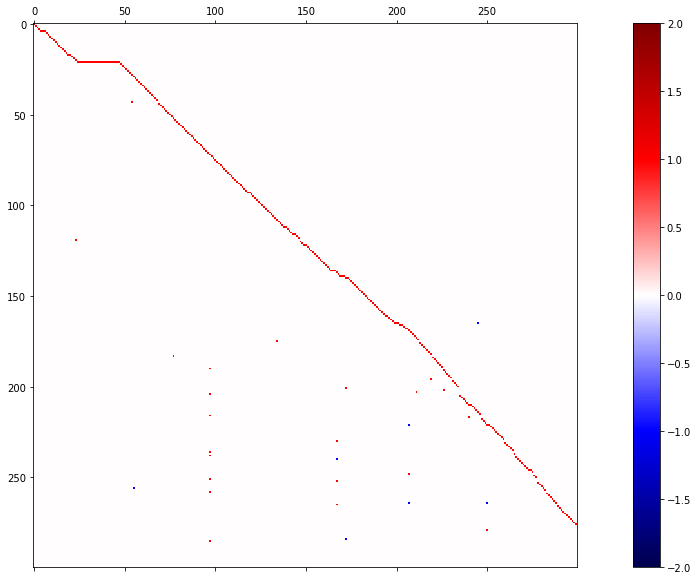

In [8]:
A = papermat.todense()
fig, axes = plt.subplots(figsize=(20, 10))
pos = axes.matshow(A[0:300,0:300], cmap='seismic',vmin=-2., vmax=2.)
fig.colorbar(pos)

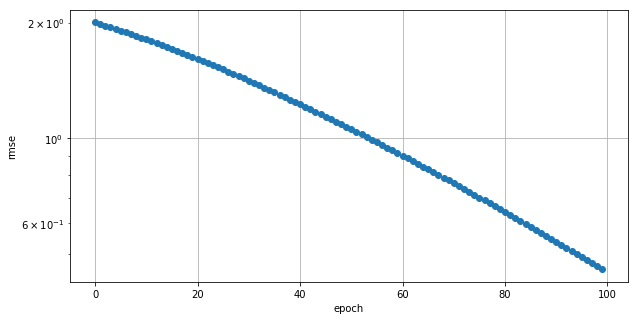

In [9]:
# Comment out following code if not using --
#  https://github.com/MelodyShih/Surprise/tree/1003-project
loss = algo.losshistory
fig, ax = plt.subplots(figsize=(10, 5))
ax.semilogy(range(len(loss)), loss, '--o')
ax.set_xlabel('epoch')
ax.set_ylabel('rmse')
plt.grid(True)

In [38]:
trainestdata = trainset.build_testset()
trainpredictions = algo.test(trainestdata, clip=False)
rmse = accuracy.rmse(trainpredictions)
print(loss[-1])

RMSE: 0.5142


NameError: name 'loss' is not defined

In [11]:
# Only work for SVD with biased = False
pu = algo.pu
qi = algo.qi

Abar = np.dot(pu, np.transpose(qi))
print(Abar.shape)
Abar = Abar - np.ones(Abar.shape)

(2556, 2300)


-2.98863531052 1.10685136322


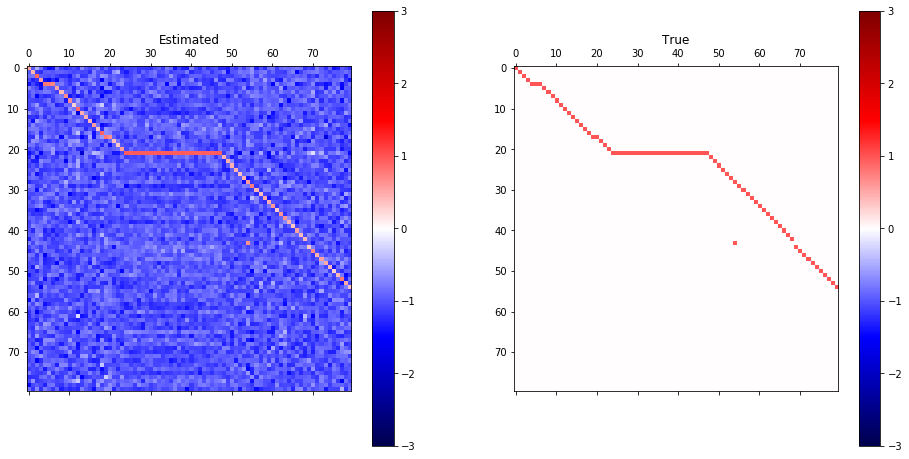

In [12]:
fig, axes = plt.subplots(1, 2)
threshold = -3

minvalue = np.amin(Abar)
maxvalue = np.amax(Abar)
print(minvalue, maxvalue)

mask = Abar[0:80, 0:80] >= threshold
pos = axes[0].matshow(Abar[0:80,0:80] , cmap='seismic',vmin=-3, vmax=3.)
axes[0].set_title('Estimated')
fig.colorbar(pos, ax=axes[0])

pos = axes[1].matshow(A[0:80, 0:80] , cmap='seismic',vmin=-3, vmax=3.)
axes[1].set_title('True')
fig.colorbar(pos, ax=axes[1])
fig.savefig('estimate_true.png')

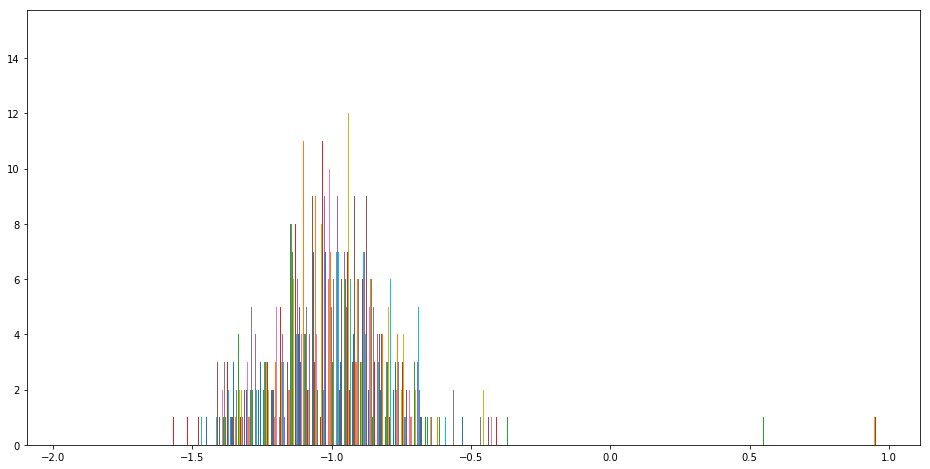

In [13]:
plt.hist(Abar[0:100, 0:100],bins=100)
plt.show()

### Comments - 
From loss and the above graph, SVD fits the training data well.

## Hyperparameter

In [16]:
print(trainset.n_users)
print(trainset.n_items)

2556
2300


### number of factors (n_factors)

In [37]:
factors_to_try = [10,50,100,500,1000]
rmse_train = np.zeros(len(factors_to_try))
rmse_test = np.zeros(len(factors_to_try))
elapsed_time = np.zeros(len(factors_to_try))
for i in range(len(factors_to_try)):
    nfactors = factors_to_try[i]
    
    t = time.time()
    algo = SVD(biased=False, n_epochs = 100, n_factors = nfactors)
    algo.fit(trainset)
    elapsed_time[i] = time.time() - t
    
    testpredictions  = algo.test(testset, clip=False)
    trainpredictions = algo.test(trainestdata, clip=False)
    
    rmse_train[i] = accuracy.rmse(trainpredictions)
    rmse_test[i]  = accuracy.rmse(testpredictions)
    print(rmse_train[i], rmse_test[i], 'time = ', elapsed_time[i])

NameError: name 'trainestdata' is not defined

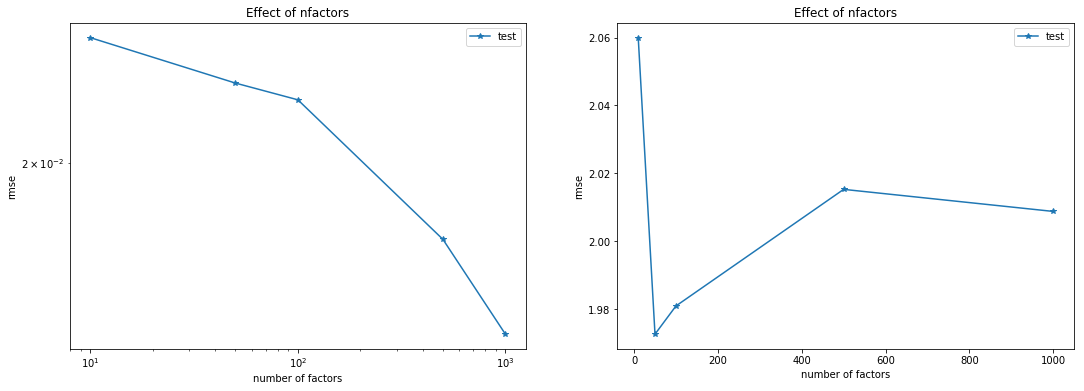

In [18]:
fig, axes = plt.subplots(1,2,figsize=(18,6))

# axes[0].plot(factors_to_try, rmse_train, '-*', label="train")
axes[0].loglog(factors_to_try, rmse_train, '-*', label="test")
axes[0].set_title('Effect of nfactors')
axes[0].set_xlabel('number of factors')
axes[0].set_ylabel('rmse')
axes[0].legend()

axes[1].plot(factors_to_try, rmse_test, '-*', label="test")
axes[1].set_title('Effect of nfactors')
axes[1].set_xlabel('number of factors')
axes[1].set_ylabel('rmse')
axes[1].legend()
fig.savefig('svd_nfactors.png')

# fig, axes = plt.subplots(figsize=(9,6))
# axes.plot(factors_to_try, elapsed_time, '-*')
# axes.set_title('Time to train the model')
# axes.set_xlabel('number of factors')
# axes.set_ylabel('seconds')

### Comments:
Changing the number of factors doens't seem to help us reduce the root mean square error (rmse).

### lambda

In [ ]:
nfactors = 50
reg_lambdas = 10**np.linspace(-3,2,6)
rmse_train_lambda = np.zeros(len(reg_lambdas))
rmse_test_lambda  = np.zeros(len(reg_lambdas))
elapsed_time = np.zeros(len(reg_lambdas))
for i in range(len(reg_lambdas)):
    reg_lambda = reg_lambdas[i]
    
    t = time.time()
    algo = SVD(biased=False, n_epochs = 300, n_factors = nfactors, reg_all=reg_lambda)
    algo.fit(trainset)
    elapsed_time[i] = time.time() - t
    
    testpredictions  = algo.test(testset, clip=False)
    trainpredictions = algo.test(trainestdata, clip=False)
    
    rmse_train_lambda[i] = accuracy.rmse(trainpredictions)
    rmse_test_lambda[i]  = accuracy.rmse(testpredictions)
    print(reg_lambda,rmse_train_lambda[i],rmse_test_lambda[i], 'time = ', elapsed_time[i])

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(18,6))

# axes[0].plot(factors_to_try, rmse_train, '-*', label="train")
axes[0].semilogx(reg_lambdas, rmse_train_lambda, '-*', label="train")
axes[0].set_title('Effect of regularization')
axes[0].set_xlabel('lambda')
axes[0].set_ylabel('rmse')
axes[0].legend()

axes[1].semilogx(reg_lambdas, rmse_test_lambda, '-*', label="test")
axes[1].set_title('Effect of regularization')
axes[1].set_xlabel('lambda')
axes[1].set_ylabel('rmse')
axes[1].legend()
fig.savefig('svd_regularization.png')

# fig, axes = plt.subplots(figsize=(9,6))
# axes.plot(reg_lambdas, elapsed_time, '-*')
# axes.set_title('Time to train the model')
# axes.set_xlabel('lambda')
# axes.set_ylabel('seconds')

## Recommendation list

In [ ]:
# this function can put in surprise
def build_data_for_prediction(self,user_ids):
    """Return a list of ratings that can be used as a testset in the
    :meth:`test() <surprise.prediction_algorithms.algo_base.AlgoBase.test>`
    method.
    """
    alldata = []
    for i in range(len(user_ids)):
        for j in range(self.n_items):
            alldata.append((self.to_raw_uid(i),self.to_raw_iid(j),0))
    return alldata

In [ ]:
# build a list to do the recommendation for user_ids
user_ids = [0]
userdata = build_data_for_prediction(trainset, user_ids)

predictions = algo.test(userdata[0:len(user_ids)], clip=False)
rec_list = evaluation.get_items_greater_threshold(predictions, -0.1)

In [ ]:
# list of papers that recommend to user_id = 0
rec_list

## Precision and Recall

In [5]:
algo = SVD(biased=False, n_epochs = 300, n_factors = 100, reg_all=1)
algo.fit(trainset)

user_ids = list(testdict.keys())
user_est_true = evaluation.prediction_for_userids(algo, trainset, testdict, user_ids)

In [4]:
thresholds = np.linspace(-3,3,100)
precision = np.zeros(len(thresholds))
recall = np.zeros(len(thresholds))
f1 = np.zeros(len(thresholds))

for t,threshold in enumerate(thresholds):
#     tt = time.time()
    precisions, recalls = evaluation.precision_recall_at_k(user_est_true, testdict, k=10, threshold=threshold)
    precision[t] = sum(prec for prec in precisions.values()) / len(precisions)
    recall[t] = sum(rec for rec in recalls.values()) / len(recalls)
    f1[t] = 2*(precision[t]*recall[t])/(precision[t]+recall[t])
#     elapsed_time = time.time() - tt
    print('threshold = ', threshold, precision[t], recall[t], f1[t])
#     print(precision_hist[t])

threshold =  -3.0 0.0208955223881 0.0934434968017 0.0341537069895
threshold =  -2.93939393939 0.0208955223881 0.0934434968017 0.0341537069895
threshold =  -2.87878787879 0.0208955223881 0.0934434968017 0.0341537069895
threshold =  -2.81818181818 0.0208955223881 0.0934434968017 0.0341537069895
threshold =  -2.75757575758 0.0208955223881 0.0934434968017 0.0341537069895
threshold =  -2.69696969697 0.0208955223881 0.0934434968017 0.0341537069895
threshold =  -2.63636363636 0.0208955223881 0.0934434968017 0.0341537069895
threshold =  -2.57575757576 0.0208955223881 0.0934434968017 0.0341537069895
threshold =  -2.51515151515 0.0208955223881 0.0934434968017 0.0341537069895
threshold =  -2.45454545455 0.0208955223881 0.0934434968017 0.0341537069895
threshold =  -2.39393939394 0.0208955223881 0.0934434968017 0.0341537069895
threshold =  -2.33333333333 0.0208955223881 0.0934434968017 0.0341537069895
threshold =  -2.27272727273 0.0208955223881 0.0934434968017 0.0341537069895
threshold =  -2.212121

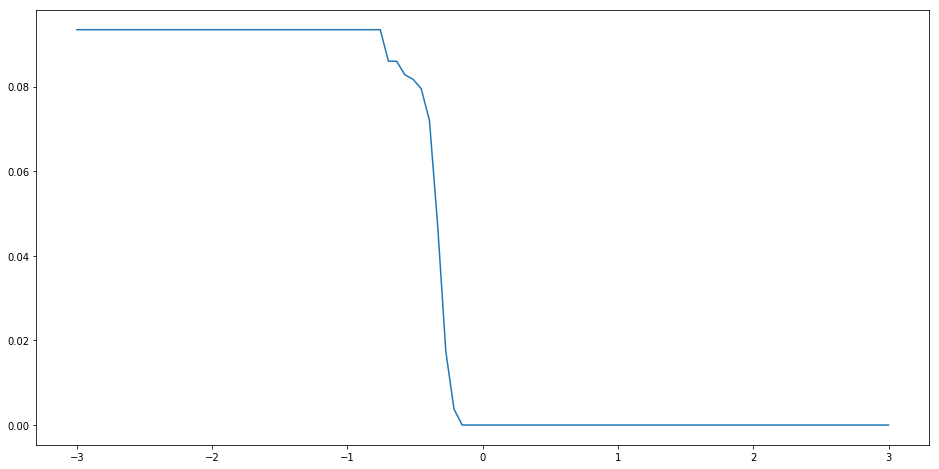

In [5]:
plt.plot(thresholds,recall)

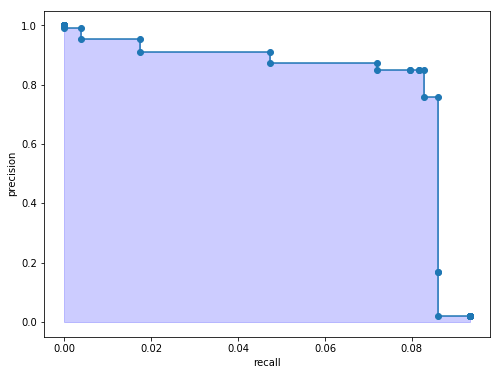

In [8]:
# plt.plot(recall,precision, '-o')
fig, axes = plt.subplots(1,1,figsize=(8,6))
axes.step(recall,precision,'-o',where='post')
axes.fill_between(recall, precision, step='post', alpha=0.2,color='b')
axes.set_xlabel('recall')
axes.set_ylabel('precision')
fig.savefig('svd_p_r.png')

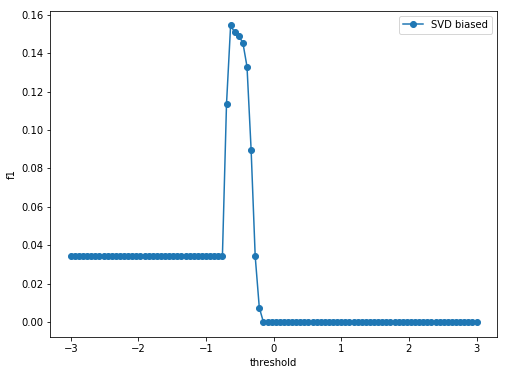

In [9]:
fig, axes = plt.subplots(1,1,figsize=(8,6))
axes.plot(thresholds,f1,'-o', label='SVD biased')
axes.set_xlabel('threshold')
axes.set_ylabel('f1')
axes.legend()
fig.savefig('svd_f1.png')

## Aggregate Diversity

In [6]:
def create_userids_iid_est_dict(algo, trainset, testdic, userids):
    user_iid_est = defaultdict(list)
    for u in userids:
        u_numid = trainset.to_inner_uid(u)
        user_items = set([j for (j, _) in trainset.ur[u_numid]])
        user_iid_est[u] = []
        for i in trainset.all_items():
            if i not in user_items :
                if trainset.to_raw_iid(i) in testdic[u]:
                    user_iid_est[u].append((trainset.to_raw_iid(i), algo.estimate(u_numid,i)-algo.trainset.offset))
                else:
                    user_iid_est[u].append((trainset.to_raw_iid(i), algo.estimate(u_numid,i)-algo.trainset.offset))
    return user_iid_est

In [7]:
user_iid_est = create_userids_iid_est_dict(algo, trainset, testdict, user_ids)

In [8]:
# user_ratings_greater_threshold.sort(key=lambda x: x[0], reverse=True)
k = 10
rec_dict = dict()
for key in user_iid_est.keys():
    user_iid_est[key].sort(key=lambda x: x[1], reverse=True)
    rec_dict[key] = [iid for (iid,value) in user_iid_est[key][0:k]]
# user_iid_est['9753c508-20e1-4f9b-baf4-f0c49008dcbc'].sort(key=lambda x: x[1], reverse=True)[0:k]

In [9]:
user_iid_est['9753c508-20e1-4f9b-baf4-f0c49008dcbc'][0:10]

[('d420ec32-539c-4765-9ec8-719889faaf86', -0.67270445101934717),
 ('48861319-449c-4dbf-affb-8976d7608748', -0.69016993879163735),
 ('978efa8a-b62a-4e76-a2a1-c3a7af5e1a60', -0.71665911016000949),
 ('fdfbfd87-0810-4825-916f-f19c682495bd', -0.71718557035317088),
 ('9146a463-a29f-43f1-a489-327d3fe7c70a', -0.71788584988551141),
 ('e6293cf6-06cb-4b81-bb92-17ceb6069d31', -0.72520844276518193),
 ('5db703f1-700a-43a7-bec2-65fa309eec33', -0.72945364231979415),
 ('64236d67-2106-4814-98e2-3de4957e39c2', -0.73081461859371677),
 ('f4ee5e5e-41ba-424f-93a2-c0b6560c1890', -0.73137008934848469),
 ('cb212f53-e76c-45e3-8d2c-e3fbb1c6b5c0', -0.73381512472587618)]

In [10]:
rec_dict['9753c508-20e1-4f9b-baf4-f0c49008dcbc']

['d420ec32-539c-4765-9ec8-719889faaf86',
 '48861319-449c-4dbf-affb-8976d7608748',
 '978efa8a-b62a-4e76-a2a1-c3a7af5e1a60',
 'fdfbfd87-0810-4825-916f-f19c682495bd',
 '9146a463-a29f-43f1-a489-327d3fe7c70a',
 'e6293cf6-06cb-4b81-bb92-17ceb6069d31',
 '5db703f1-700a-43a7-bec2-65fa309eec33',
 '64236d67-2106-4814-98e2-3de4957e39c2',
 'f4ee5e5e-41ba-424f-93a2-c0b6560c1890',
 'cb212f53-e76c-45e3-8d2c-e3fbb1c6b5c0']

In [11]:
test = utils.invert_dict(rec_dict)

In [13]:
test['d420ec32-539c-4765-9ec8-719889faaf86']

['9753c508-20e1-4f9b-baf4-f0c49008dcbc',
 '59c62c71-1bfc-425e-82f5-b5962b4349a5']

In [14]:
# Diversity
len(test.keys())

939